In [252]:
##################################### HELPER FUNCTIONS AND CONFIGURATIONS #########################################

import seaborn as sns # for data visualization
from matplotlib.collections import PathCollection
import os
import pprint
import random
import statistics
import scipy.stats
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['figure.figsize'] = [15, 10]
import json
import pandas as pd
import glob
%matplotlib inline

pp       =  pprint.PrettyPrinter(compact=True)

LOGFILES =  glob.glob('../logs/cleps-logs/17022022/*' )

print(LOGFILES)

#=== line colors and styles

linestyles = {
    #=======scenarios========
    'empty'      :   'dotted',
    'canonical'  :   'dashed',
    'floorplan'  :  'dashdot',
    #=======algorithms=======
    #------exploration------- 
    'Atlas'      :    'solid',
    #----relay placement-----
    'Recovery'   :    'solid',
    'SelfHealing':    'solid',
    'Naive'      :    'solid',
}

linecolors = {
    #=======scenarios==========
    'empty'      :      'green',
    'canonical'  :       'blue',
    'floorplan'  :        'red',
    #=======algorithms=========
    #------exploration---------
    'Atlas'      :  'royalblue',
    #------relay placement-----
    'Recovery'   :     'purple',
    'SelfHealing':      'green',
    'Naive'      :     'orange',
     
   }

#=== helper functions

def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return (m, h)

['../logs/cleps-logs/17022022\\Atlas_log_cleps_1_220217121112_0.11282039713078929.json', '../logs/cleps-logs/17022022\\Atlas_log_cleps_1_220217121112_0.38383497935984023.json', '../logs/cleps-logs/17022022\\Atlas_log_cleps_1_220217145758_0.47847878260675125.json', '../logs/cleps-logs/17022022\\Atlas_log_cleps_1_220217145758_0.870179460112924.json', '../logs/cleps-logs/17022022\\Atlas_log_cleps_2_220217152042_0.7620240743403693.json', '../logs/cleps-logs/17022022\\Atlas_log_cleps_2_220217152815_0.0852205762490521.json']


In [253]:
#==================================================== GATHER DATA =============================================
data = []
configs    = set()
for file in LOGFILES:
    FILENAME = file

    time       = []
    pdrs       = []
    avg_pdr    = []
    num_relays = []
    num_cells  = []
    run_data   = {}
    config     = None


    # gather
    with open(FILENAME,'r') as f:
        for line in f.readlines():
            jsonline = json.loads(line)
            if jsonline["type"] == "sim configuration":
                config = jsonline
                configs.add(str(config))
            if jsonline["type"]!='timeseries_kpi':
                continue

            # store
            time       += [jsonline["time"]]
            pdrs       += [[e[2] for e in jsonline["pdrProfile"]]]
            num_relays += [len([e[3] for e in jsonline["pdrProfile"] if e[3]])]
            num_cells  += [jsonline["mappingProfile"]]
            
        
        run_data['config']          = config
        run_data['time']            = time
        run_data['pdrs']            = pdrs
        run_data['num_relays']      = num_relays
        run_data['mappingProfile']  = num_cells

        data.append(run_data)


In [254]:
#----- aggregate config file data 
grouped_config_data = []

for config in configs:
    data_to_add = [run for run in data if str(run['config']) == config]
    grouped_config_data += [data_to_add]



No handles with labels found to put in legend.


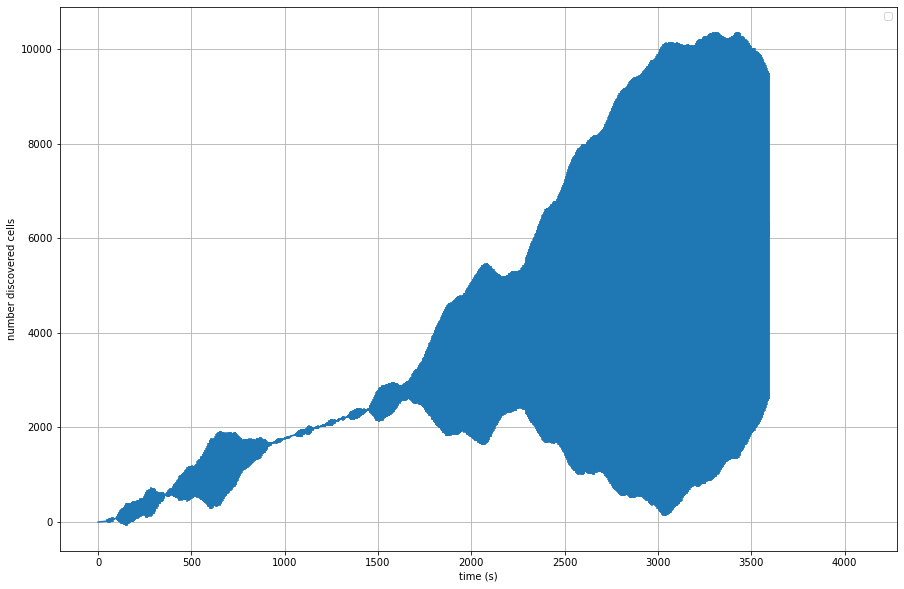

No handles with labels found to put in legend.


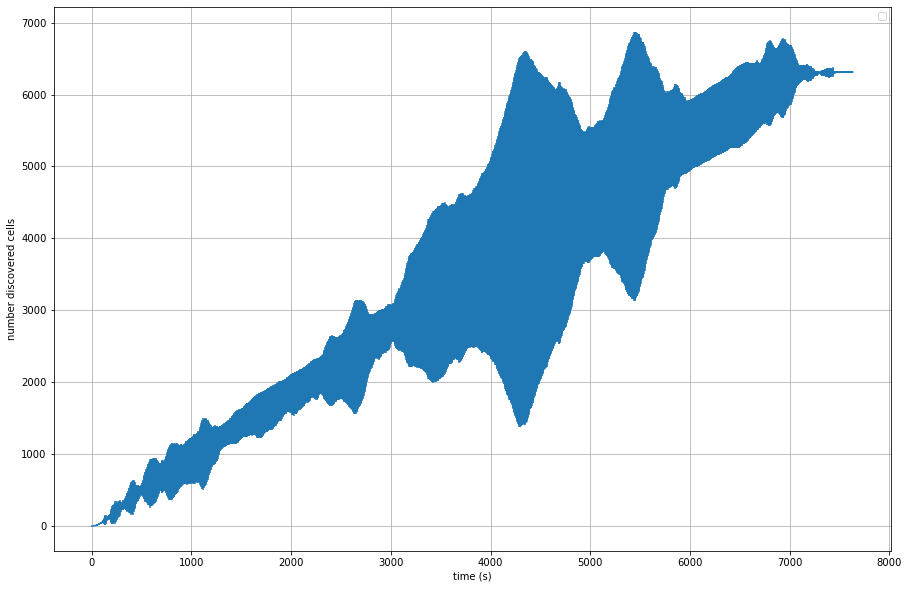

In [255]:
#===================================== MAPPING PROFILE=================================
plt.rcParams['figure.figsize'] = [15, 10]
completion_times = []
mapping_profiles = {}
data = {}
for idx,config_run in enumerate(grouped_config_data):
    config = config_run[idx]['config']
    mapping_profiles[str(config)] = [run['mappingProfile'] for run in config_run]

for config,profiles in mapping_profiles.items():
    maxlen  = max(len(p) for p in profiles)
    ms      = []
    hs      = []
    for i in range(maxlen):
        l = []
        for p in profiles:
            try:
                l += [p[i]]
            except IndexError:
                pass
            (m,h) = mean_confidence_interval(l)
            ms += [m]
            hs += [h]
        data[config] = {
            'mean':                ms,
            'confidence_interval': hs,
             }

        
for config in configs:
    (fig,ax) = plt.subplots()
    lines    = {}
    for c,profile in data.items():
        if c != config:
            continue
        x             = range(len(profile['mean']))
        y             = profile['mean']
        yerr          = profile['confidence_interval']
        lines[c]      = ax.errorbar(x=x,y=y,yerr=yerr)
    
    ax.grid(True, zorder=5)
    plt.xlabel('time (s)')
    plt.ylabel('number discovered cells')
    plt.legend()
    plt.show()

        
    
        
        
    

No handles with labels found to put in legend.


1.0


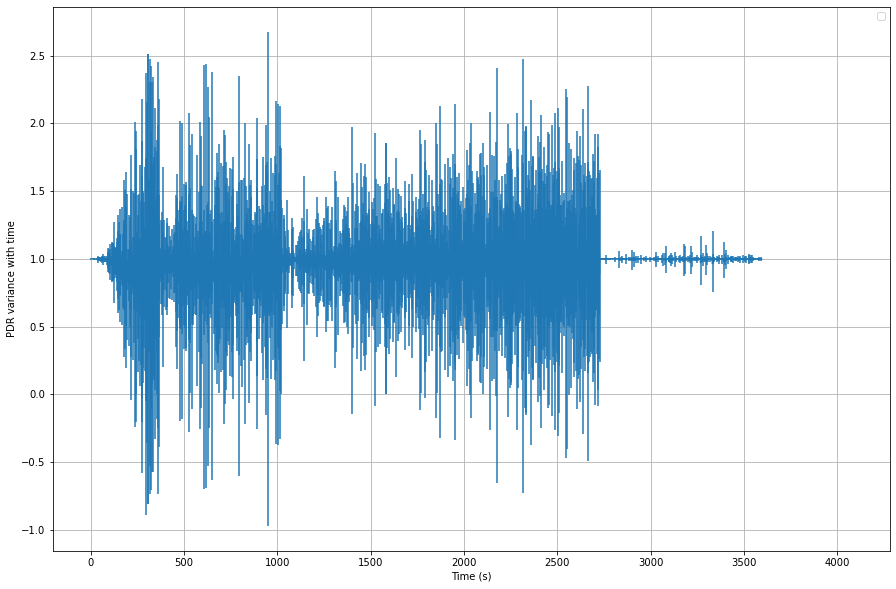

1.0

No handles with labels found to put in legend.


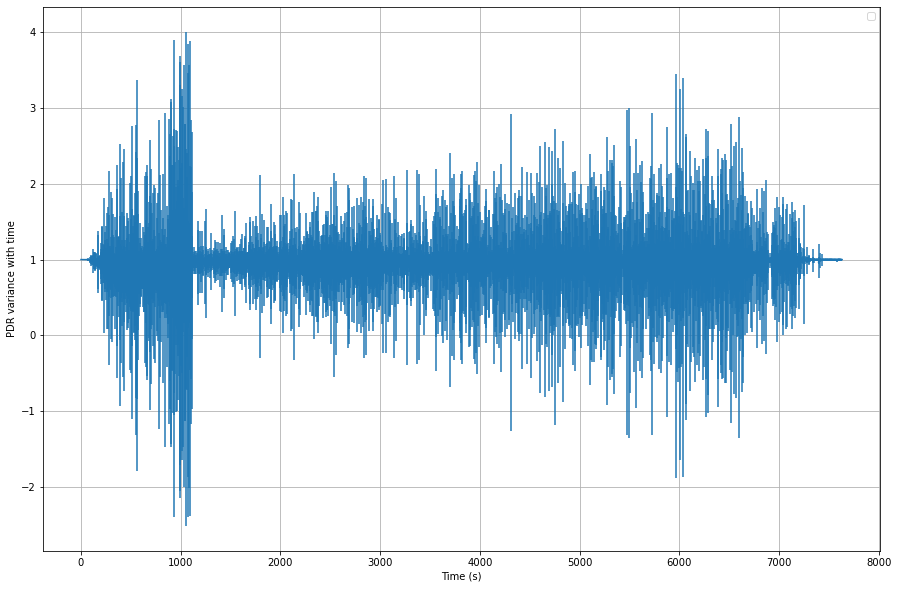

In [256]:
#================================== AVERAGE PDR AND RELAY PLACEMENT ==================================================
plt.rcParams['figure.figsize'] = [15, 10]
completion_times = []
avg_pdr_profiles = {}
data = {}
for idx,config_run in enumerate(grouped_config_data):
    config = config_run[idx]['config']
    avg_pdr_profiles[str(config)] = []
    pdr_profiles  = [run['pdrs'] for run in config_run]
    for profile in pdr_profiles:
        avg_pdr_profiles[str(config)] += [[(float(sum(p))/len(p)) for p in profile ]]

for config,profiles in avg_pdr_profiles.items():
    maxlen  = max(len(p) for p in profiles)
    ms      = []
    hs      = []
    for i in range(maxlen):
        l = []
        for p in profiles:
            try:
                l += [p[i]]
            except IndexError:
                pass
            (m,h) = mean_confidence_interval(l)
            ms += [m]
            hs += [h]
        data[config] = {
            'mean':                ms,
            'confidence_interval': hs,
             }

    
for config in configs:
    (fig,ax) = plt.subplots()
    lines    = {}
    for c,profile in data.items():
        if c != config:
            continue
        x             = range(len(profile['mean']))
        y             = profile['mean']
        print(max(y))
        yerr          = profile['confidence_interval']
        lines[c]      = ax.errorbar(x=x,y=y,yerr=yerr)
    
    ax.grid(True, zorder=5)
    plt.xlabel('Time (s)')
    plt.ylabel('PDR variance with time')

    plt.legend()
    alllines = lines
    plt.show()

In [ ]:
"============================================================"